<h3>Load libraries</h3>

In [1371]:
import numpy as np
import pandas as pd
from pandas.plotting import andrews_curves
import seaborn as sns
import re
import time
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


<h3>Initialize functions</h3>
<p>
    <b>init_check</b> - outputs column main information <br>
    <b>lower_replace</b> - translates to lower case and replaces "-" и "_" <br>
</p>

In [1372]:
def init_check(df):
    columns = df.columns    
    lst = []
    for feature in columns : 
        dtype = df[feature].dtypes
        num_null = df[feature].isnull().sum()
        num_unique = df[feature].nunique()
        lst.append([feature, dtype, num_null, num_unique])
    
    check_df = pd.DataFrame(lst)
    check_df.columns = ['feature','dtype','num_null','num_unique']
    return check_df

def lower_replace(x): 
    if type(x) == np.str:
        for i in '!@#$%^&*()_+-:;.,/':
            x = x.replace(i, '')
        x = x.lower() 
        return x
    else: return x
    

In [1373]:
labels_col = ['age', 'workclass', 'final_weight', 'education', 'education_num', 'marital_status', 
          'occupation', 'relationship', 'race', 'sex', 'cap_gain', 'cap_loss', 
          'hours_per_week', 'native_country', 'target']

data = pd.read_csv('data_dont_change.txt', sep=',', skipinitialspace=True, 
                   names=labels_col, comment='.', error_bad_lines=False)
init_check(data)

,feature,dtype,num_null,num_unique
0,age,int64,0,75
1,workclass,object,0,9
2,final_weight,int64,0,21650
3,education,object,0,16
4,education_num,object,0,17
5,marital_status,object,0,8
6,occupation,object,0,16
7,relationship,object,0,8
8,race,object,0,5
9,sex,object,0,4


In [1374]:
target_values = data['target'].value_counts()
print(target_values)
print("\nPercent of \'>N\': ", round((target_values['>N']/target_values.sum())*100, 2))

<=N    24720
>N      7851
Name: target, dtype: int64

Percent of '>N':  24.1


In [1375]:
%%time
data = data.applymap(lambda x: lower_replace(x))
data.head()

CPU times: user 866 ms, sys: 167 ms, total: 1.03 s
Wall time: 1.57 s


,age,workclass,final_weight,education,education_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country,target
0,39,stategov,77516,bachelors,13,nevermarried,admclerical,notinfamily,white,male,2174,0,40,unitedstates,<=n
1,50,selfempnotinc,83311,bachelors,13,marriedcivspouse,execmanagerial,husband,white,male,0,0,13,unitedstates,<=n
2,38,private,215646,hsgrad,9,divorced,handlerscleaners,notinfamily,white,male,0,0,40,unitedstates,<=n
3,53,private,234721,11th,7,marriedcivspouse,handlerscleaners,husband,black,male,0,0,40,unitedstates,<=n
4,28,private,338409,bachelors,13,marriedcivspouse,profspecialty,wife,black,female,0,0,40,cuba,<=n


<h3>"age"</h3>

<AxesSubplot:xlabel='age'>

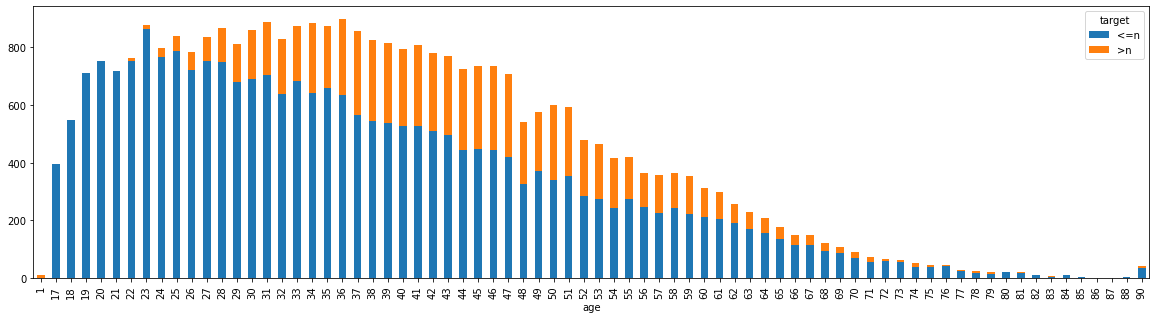

In [1376]:
pd.crosstab(data.age,data.target).plot(kind='bar', figsize=(20,5), stacked=True)

<p>
    It's evident that people start to earn more than N at the age of 22, so young people earn less than middle-aged. 
</p>
<p> 
    To simplify the data I will separate samples by age. In the group "young" fall ages from 0 to 22, in "middleaged" - from 23 to 49, in "senior" - from 50 to 65, in "old" - from 66 to 100.
</p>

['young', 'middleaged', 'senior', 'old']


<AxesSubplot:xlabel='age_new'>

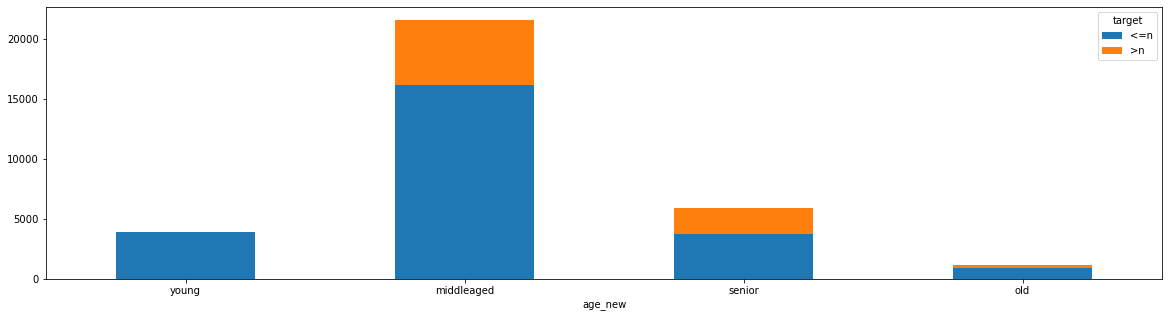

In [1377]:
bins = [0, 22, 49, 65, 100]
age_names = ['young', 'middleaged', 'senior', 'old']
data['age_new'] = pd.cut(data['age'], bins, labels=age_names)

print(age_names)
pd.crosstab(data.age_new,data.target).plot(kind='bar', figsize=(20,5), stacked=True, rot=0)

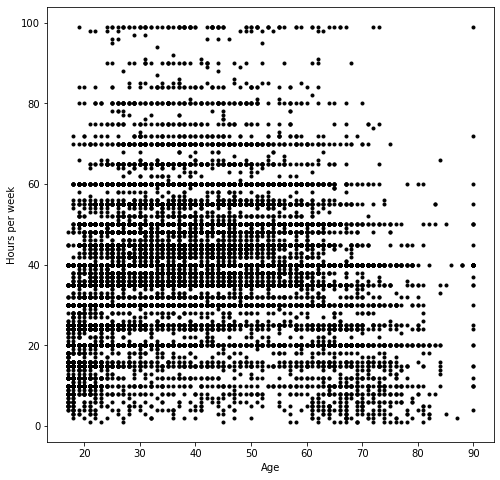

In [1462]:
plt.figure(figsize=(8,8))
new = data[['age', 'hours_per_week']].copy().astype(int)
new = new.sort_values(['age'])
del_i = new[new['hours_per_week'] > (24*7)].index
new.drop(del_i, axis=0, inplace=True)
plt.plot(new['age'], new['hours_per_week'], '.k')
plt.xlabel('Age')
plt.ylabel('Hours per week')
plt.show()

We can see the average changes of the number of working hours during life.

<h3>"workclass"</h3>


Unique categories:
 ['stategov' 'selfempnotinc' 'private' 'federalgov' 'localgov' '?'
 'selfempinc' 'withoutpay' 'neverworked']


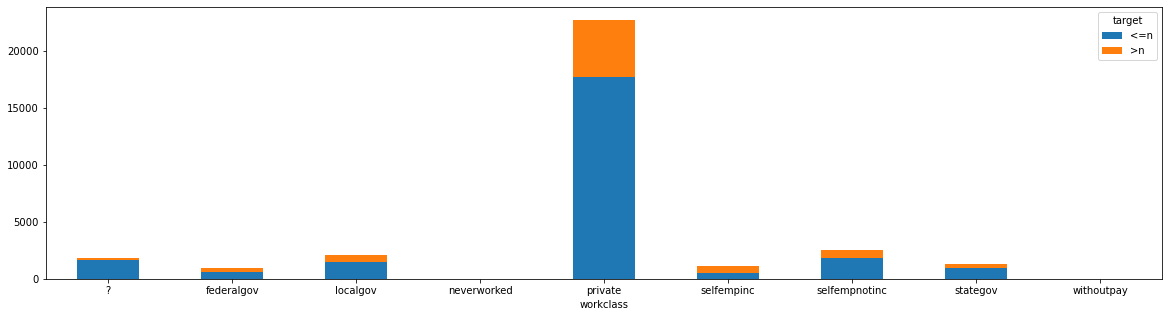

In [1379]:
pd.crosstab(data.workclass,data.target).plot(kind='bar', figsize=(20,5), stacked=True, rot=0)
print('\nUnique categories:\n', data['workclass'].unique())

In [1380]:
data.groupby('workclass').target.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

workclass      target
?              <=n        89.6%
               >n         10.4%
federalgov     <=n        61.4%
               >n         38.6%
localgov       <=n        70.5%
               >n         29.5%
neverworked    <=n       100.0%
private        <=n        78.1%
               >n         21.9%
selfempinc     >n         55.7%
               <=n        44.3%
selfempnotinc  <=n        71.5%
               >n         28.5%
stategov       <=n        72.2%
               >n         27.8%
withoutpay     <=n       100.0%
Name: target, dtype: object


<p>
    <ol>
        <li>Most of the people are in the "private" category</li>
        <li>The biggest percent of the people earning more than N presented in "selfempinc" (self-employed incorporated) - 55.7%</li>
        <li>The biggest percent of the people earning less than N presented in "private" - 78.1%</li>
        <li>The "?" is not random, since the percent of '>N' among the "?" does not correspond to a percent of '>N' in a subdataset of randomly chosen samples (24%)</li>
    </ol>
</p>
<p> 
    I will...
    <ol>
        <li>merge all the "selfemp..." categories to one - "selfemp"</li>
        <li>merge "withoutpay" and "neverworked" to "nopay"</li>
        <li>merge all the "...gov" to one - "govemp"</li> 
        <li>create category "unknown" for samples in "?"</li>
    </ol>
</p>

In [1381]:
data['workclass_new'] = data['workclass']
data['workclass_new'].replace(['stategov', 'federalgov', 'localgov'], 'govemp', inplace=True)
data['workclass_new'].replace(['selfempnotinc', 'selfempinc'], 'selfemp', inplace=True)
data['workclass_new'].replace(['withoutpay', 'neverworked'], 'nopay', inplace=True)
data['workclass_new'].replace('?', 'unknown', inplace=True)

<AxesSubplot:xlabel='workclass_new'>

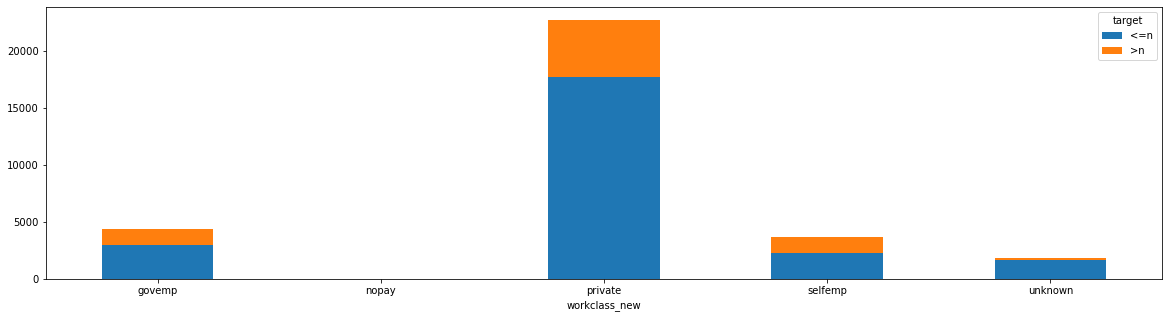

In [1382]:
pd.crosstab(data.workclass_new,data.target).plot(kind='bar', figsize=(20,5), stacked=True, rot=0)

<h3>"education" and "education_num"</h3>

In [1383]:
print(data.groupby('education').education_num.value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

education    education_num  
10th         6                  100.0%
11th         7                  100.0%
12th         8                  100.0%
1st4th       2                  100.0%
5th6th       3                  100.0%
7th8th       4                  100.0%
9th          5                  100.0%
assocacdm    12                 100.0%
assocvoc     11                 100.0%
bachelors    13                 100.0%
doctorate    16                 100.0%
hsgrad       9                  100.0%
masters      14                 100.0%
preschool    1                  100.0%
profschool   15                 100.0%
somecollege  10                 100.0%
             machineopinspct      0.0%
Name: education_num, dtype: object


<p>It's obvious that we don't need both "education_num" and "education" together. I'll drop one of them later.</p>

education    target
10th         <=n        93.4%
             >n          6.6%
11th         <=n        94.9%
             >n          5.1%
12th         <=n        92.4%
             >n          7.6%
1st4th       <=n        96.4%
             >n          3.6%
5th6th       <=n        95.2%
             >n          4.8%
7th8th       <=n        93.8%
             >n          6.2%
9th          <=n        94.7%
             >n          5.3%
assocacdm    <=n        75.2%
             >n         24.8%
assocvoc     <=n        73.9%
             >n         26.1%
bachelors    <=n        58.5%
             >n         41.5%
doctorate    >n         74.1%
             <=n        25.9%
hsgrad       <=n        84.0%
             >n         16.0%
masters      >n         55.7%
             <=n        44.3%
preschool    <=n       100.0%
profschool   >n         73.4%
             <=n        26.6%
somecollege  <=n        80.9%
             >n         19.1%
Name: target, dtype: object

Unique categories:
 [

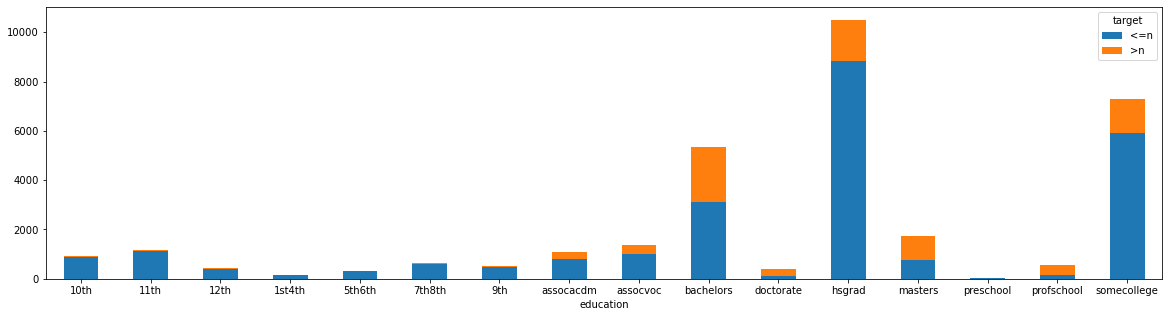

In [1384]:
pd.crosstab(data.education,data.target).plot(kind='bar', figsize=(20,5), stacked=True, rot=0)
print(data.groupby('education').target.value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
print('\nUnique categories:\n', data['education'].unique())


<p>
    <ol>
        <li>There is almost no chance to earn more than N with only school education</li>
        <li>There is the highest probability of earning more than N if you have doctor degree or profscool education  </li>
    </ol>
</p>
<p> 
    I will merge some categories in the code below.
</p>

In [1385]:
data['education_new'] = data['education']
data['education_new'].replace(['5th6th','10th','1st4th','preschool','12th','9th','7th8th','11th'], 'school', inplace=True)
data['education_new'].replace(['assocacdm','assocvoc'], 'assoc', inplace=True)
data.drop(['education'], axis=1, inplace=True)

<AxesSubplot:xlabel='education_new'>

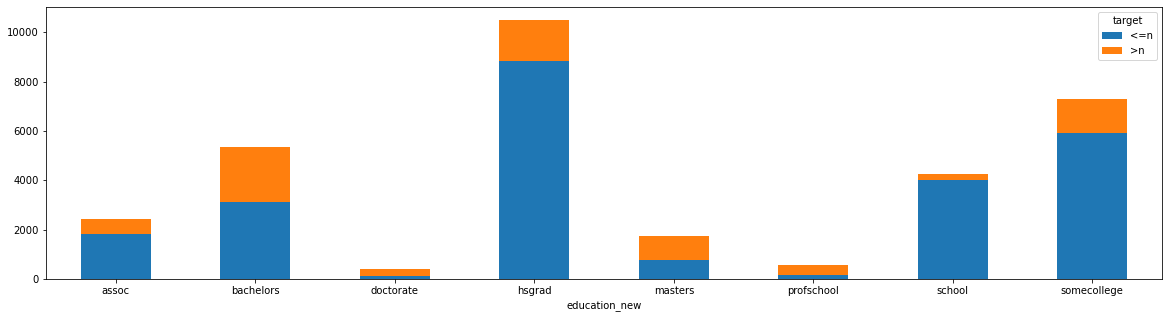

In [1386]:
pd.crosstab(data.education_new,data.target).plot(kind='bar', figsize=(20,5), stacked=True, rot=0)

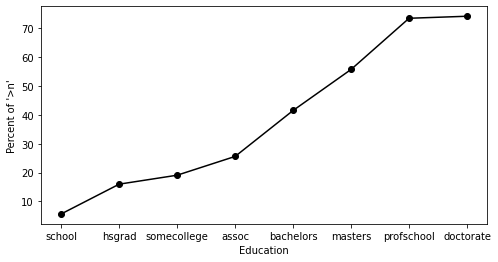

In [1387]:
groupby = data.groupby('education_new').target.value_counts(normalize=True).mul(100).round(1)
edn_in_order = ['school', 'hsgrad', 'somecollege', 'assoc', 'bachelors', 'masters', 'profschool','doctorate']
more_n_prob = []

for i in edn_in_order:
    more_n_prob.append(groupby[(i, '>n')])

plt.figure(figsize=(8,4))
plt.ylabel('Percent of \'>n\'')
plt.xlabel('Education')
plt.plot(edn_in_order, more_n_prob, 'o-k')

The better education you have the more you earn

<h3>"native_country"</h3>

In [1388]:
print('\n\n',(round((data['native_country'].value_counts(normalize=True)).mul(100), 3)).astype(str) + '%')



 unitedstates             89.586%
mexico                    1.974%
?                          1.79%
philippines               0.608%
germany                   0.421%
canada                    0.371%
puertorico                 0.35%
elsalvador                0.325%
india                     0.307%
cuba                      0.292%
england                   0.276%
jamaica                   0.249%
south                     0.246%
china                      0.23%
italy                     0.224%
dominicanrepublic         0.215%
vietnam                   0.206%
guatemala                 0.196%
japan                      0.19%
poland                    0.184%
columbia                  0.181%
taiwan                    0.157%
haiti                     0.135%
iran                      0.132%
portugal                  0.114%
nicaragua                 0.104%
peru                      0.095%
france                    0.089%
greece                    0.089%
ecuador                   0.086%
ireland

<AxesSubplot:xlabel='native_country'>

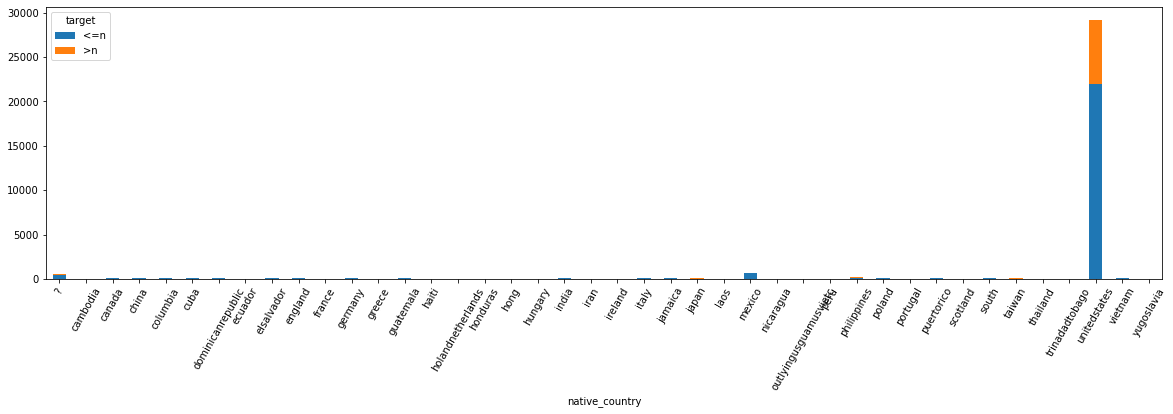

In [1389]:
pd.crosstab(data.native_country,data.target).plot(kind='bar', figsize=(20,5), stacked=True, rot=60)


<p>Overwhelming majority of samples pertain to 'unitedstates' category, therefore it might be better if I redivide the samples in more balanced categories</p>
<p>So I will make two groups: US-citizens and non-US-citizens.</p>

In [1390]:
data['native_country_new'] = data['native_country']
data['native_country_new'].replace(['unitedstates', 'south', 'outlyingusguamusvietc'], 'us', inplace=True)
data['native_country_new'].where(data['native_country_new'] == 'us', 'nonus', inplace=True)

<AxesSubplot:xlabel='native_country_new'>

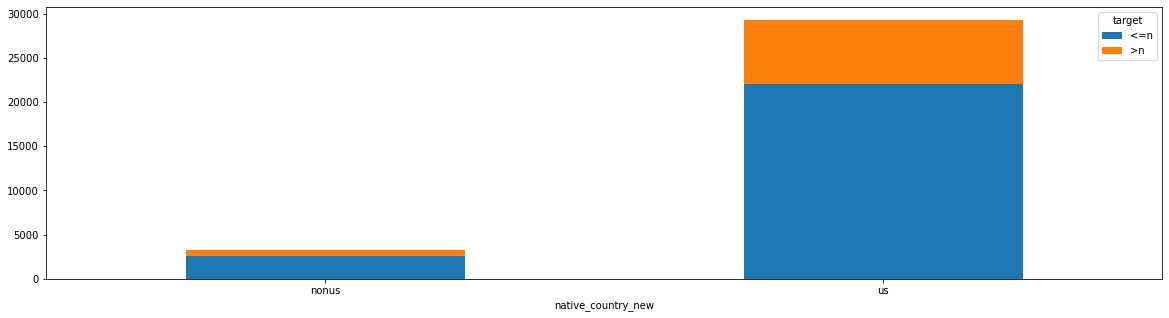

In [1391]:
pd.crosstab(data.native_country_new,data.target).plot(kind='bar', figsize=(20,5), stacked=True, rot=0)

In [1392]:
print(data.groupby('native_country_new').target.value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

native_country_new  target
nonus               <=n       80.2%
                    >n        19.8%
us                  <=n       75.4%
                    >n        24.6%
Name: target, dtype: object


<p>We can see that chances of earing more than N do not differ much in new groups.</p>

<h3>"marital_status"</h3>

marital_status       target
divorced             <=n       89.6%
                     >n        10.4%
marriedafspouse      <=n       56.5%
                     >n        43.5%
marriedcivspouse     <=n       55.3%
                     >n        44.7%
marriedspouseabsent  <=n       91.9%
                     >n         8.1%
nevermarried         <=n       95.3%
                     >n         4.7%
separated            <=n       93.6%
                     >n         6.4%
widowed              <=n       91.4%
                     >n         8.6%
Name: target, dtype: object


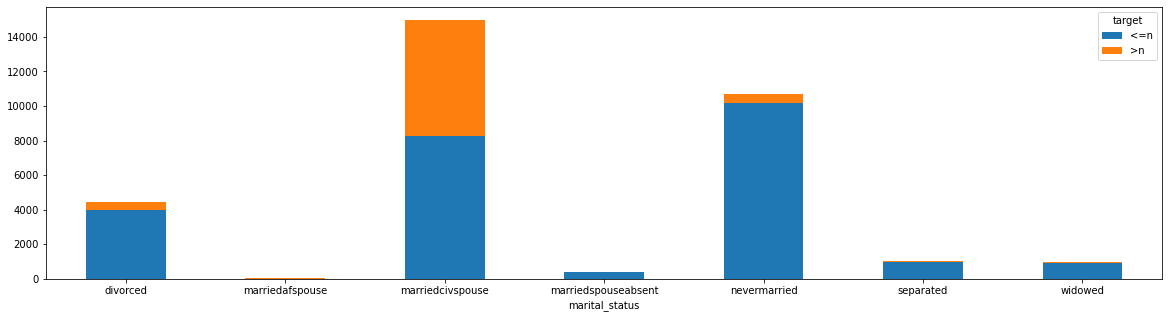

In [1393]:
pd.crosstab(data.marital_status,data.target).plot(kind='bar', figsize=(20,5), stacked=True, rot=0)
print(data.groupby('marital_status').target.value_counts(normalize=True).mul(100).round(1).astype(str) + '%')


<p>
    <ol>
        <li>People with a civilian spouse have the highest probability of earning more than N</li>
        <li>For some reasons single people predominantly earn less than N</li>
    </ol>
</p>
<p>I'll divide the samples in "single" and "married".</p>

In [1394]:
data['marital_status_new'] = data['marital_status']
data['marital_status_new'].replace(['marriedafspouse', 'marriedcivspouse'], 'married', inplace=True)
data['marital_status_new'].where(data['marital_status_new'] == 'married', 'single', inplace=True)

<AxesSubplot:xlabel='marital_status_new'>

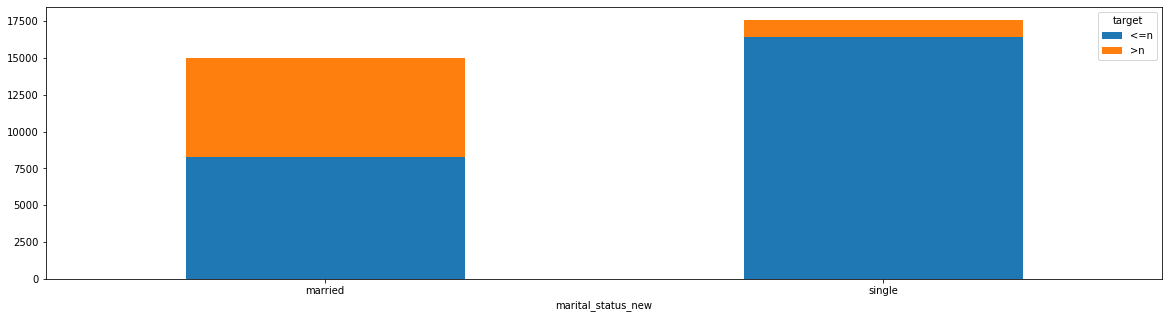

In [1395]:
pd.crosstab(data.marital_status_new,data.target).plot(kind='bar', figsize=(20,5), stacked=True, rot=0)

<h3>"relationship"</h3>

In [1396]:
print(data['marital_status'].unique())
print(data['relationship'].unique())

['nevermarried' 'marriedcivspouse' 'divorced' 'marriedspouseabsent'
 'separated' 'marriedafspouse' 'widowed' 'sales']
['notinfamily' 'husband' 'wife' 'ownchild' 'unmarried' 'otherrelative'
 'white' 'sales']


<p>Let's delete apparently wrong categories: "sales" and "white"</p>

In [1397]:
data['marital_status'].replace(['sales'], np.nan, inplace=True)
data['relationship'].replace(['sales', 'white'], np.nan, inplace=True)

marital_status_new  relationship 
married             husband          88.0%
                    wife             10.5%
                    otherrelative     0.8%
                    ownchild          0.6%
                    notinfamily       0.1%
single              notinfamily      47.2%
                    ownchild         28.3%
                    unmarried        19.6%
                    otherrelative     4.9%
Name: relationship, dtype: object


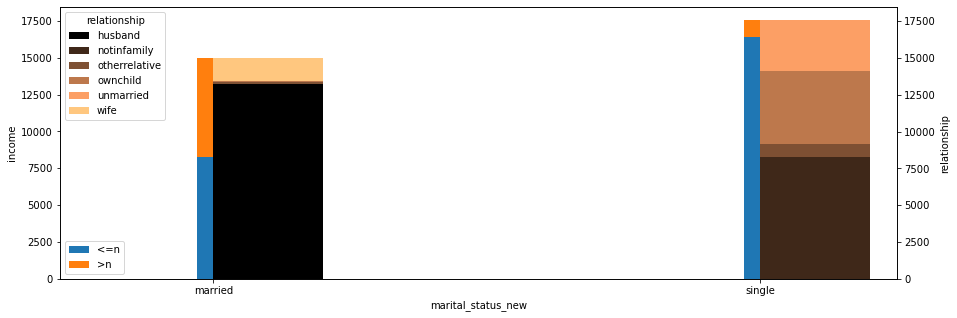

In [1398]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

pd.crosstab(data.marital_status_new,data.relationship).plot(kind='bar', figsize=(15,5), rot=0, ax=ax1, position=0, width=0.2,
                                                            stacked=True, colormap=plt.get_cmap('copper'))
pd.crosstab(data.marital_status_new,data.target).plot(kind='bar', figsize=(15,5), ax=ax2, position=1, width=0.03,
                                                      stacked=True, rot=0)

ax1.set_ylabel('income')
ax2.set_ylabel('relationship')
h, l = ax2.get_legend_handles_labels()
ax2.legend(h, l, loc=3)

print(data.groupby('marital_status_new').relationship.value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

 <p>New marital status categories match relationship categories well.</p>

relationship   target
husband        <=n       55.1%
               >n        44.9%
notinfamily    <=n       89.7%
               >n        10.3%
otherrelative  <=n       96.2%
               >n         3.8%
ownchild       <=n       98.7%
               >n         1.3%
unmarried      <=n       93.7%
               >n         6.3%
wife           <=n       52.5%
               >n        47.5%
Name: target, dtype: object


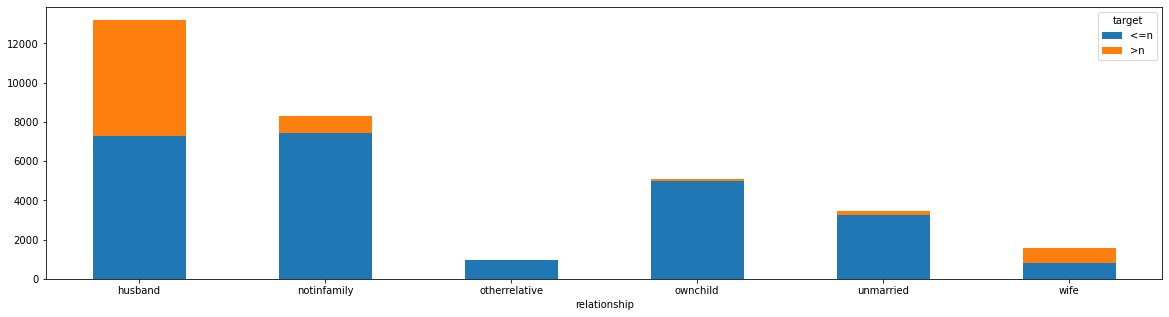

In [1399]:
pd.crosstab(data.relationship,data.target).plot(kind='bar', figsize=(20,5), stacked=True, rot=0)
print(data.groupby('relationship').target.value_counts(normalize=True).mul(100).round(1).astype(str) + '%')


<p>
"marital_status" seems useless, because the information whether a person is married or single can be represented by "wife" and "husband" categories merged in new category - "spouse" - and other categories in "relationship" feature.
</p>

In [1400]:
data['relationship_new'] = data['relationship']
data['relationship_new'].replace(['husband', 'wife'], 'spouse', inplace=True)

<h3>"occupation"</h3>

In [1401]:
data['occupation'].replace(['husband'], np.nan, inplace=True)
print(data['occupation'].unique())

['admclerical' 'execmanagerial' 'handlerscleaners' 'profspecialty'
 'otherservice' 'sales' 'craftrepair' 'transportmoving' 'farmingfishing'
 'machineopinspct' 'techsupport' '?' 'protectiveserv' 'armedforces'
 'privhouseserv' nan]


In [1402]:
pd.DataFrame(data.groupby('occupation').target.value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

target
occupation       target       
?                <=n     89.6%
                 >n      10.4%
admclerical      <=n     86.6%
                 >n      13.4%
armedforces      <=n     88.9%
                 >n      11.1%
craftrepair      <=n     77.3%
                 >n      22.7%
execmanagerial   <=n     51.6%
                 >n      48.4%
farmingfishing   <=n     88.4%
                 >n      11.6%
handlerscleaners <=n     93.7%
                 >n       6.3%
machineopinspct  <=n     87.1%
                 >n      12.9%
otherservice     <=n     95.8%
                 >n       4.2%
privhouseserv    <=n     99.3%
                 >n       0.7%
profspecialty    <=n     55.1%
                 >n      44.9%
protectiveserv   <=n     67.5%
                 >n      32.5%
sales            <=n     73.1%
                 >n      26.9%
techsupport      <=n     69.5%
                 >n      30.5%
transportmoving  <=n     80.0%
                 >n      20.0%

In [1403]:
pd.DataFrame(data.groupby('occupation').workclass_new.value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

workclass_new
occupation       workclass_new              
?                unknown               99.6%
                 nopay                  0.4%
admclerical      private               75.1%
                 govemp                22.6%
                 selfemp                2.1%
                 nopay                  0.1%
armedforces      govemp               100.0%
craftrepair      private               77.9%
                 selfemp               15.5%
                 govemp                 6.5%
                 nopay                  0.0%
execmanagerial   private               66.2%
                 selfemp               19.5%
                 govemp                14.3%
farmingfishing   selfemp               48.4%
                 private               45.8%
                 govemp                 5.2%
                 nopay                  0.6%
handlerscleaners private               92.9%
                 govemp                 5.8%
                 selfemp                1.2%
                 nopay                  0.1%
machineopinspct  private               95.1%
                 govemp                 2.4%
                 selfemp                2.4%
                 nopay                  0.0%
otherservice     private               83.2%
                 govemp                10.7%
                 selfemp                6.1%
                 nopay                  0.0%
privhouseserv    private              100.0%
profspecialty    private               55.9%
                 govemp                31.3%
                 selfemp               12.9%
protectiveserv   govemp                69.0%
                 private               29.3%
                 selfemp                1.7%
sales            private               80.6%
                 selfemp               18.5%
                 govemp                 0.9%
techsupport      private               79.3%
                 govemp                17.6%
                 selfemp                3.1%
transportmoving  private               79.3%
                 govemp                11.3%
                 selfemp                9.3%
                 nopay                  0.1%

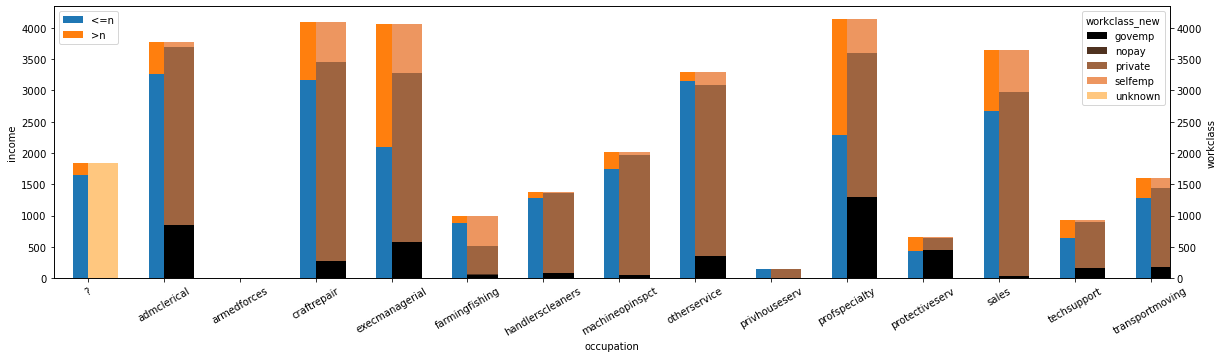

In [1404]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

pd.crosstab(data.occupation, data.workclass_new).plot(kind='bar', figsize=(20,5), ax=ax1, position=0, width=0.4,
                                                      stacked=True, colormap=plt.get_cmap('copper'), rot=30)
pd.crosstab(data.occupation,data.target).plot(kind='bar', figsize=(20,5), width=0.2,stacked=True, ax=ax2, position=1)

ax1.set_ylabel('income')
ax2.set_ylabel('workclass')
h, l = ax2.get_legend_handles_labels()
ax2.legend(h, l, loc=2)

plt.show()


<p>
    <ol>
        <li>The unknown occupation ("?") correspond for 99.6% to the unknown workclass. </li>
        <li>"Private" is found in all categories (except "armedforces" and "?") and is a dominant workclass (except "protectiveserv" and "farmingfishing")</li>
    </ol>
</p>
<p>
There is room to merge some categories. See code and plot below.
</p>

In [1405]:
data['occupation_new'] = data['occupation']
data['occupation_new'].replace(['?'], 'unknown', inplace=True)
data['occupation_new'].replace(['admclerical','execmanagerial','techsupport'], 'whitecollar', inplace=True)
data['occupation_new'].replace(['protectiveserv', 'armedforces'], 'protect', inplace=True)
data['occupation_new'].replace(['otherservice', 'privhouseserv'], 'service', inplace=True)
data['occupation_new'].replace(['handlerscleaners', 'craftrepair', 'transportmoving',
                                'farmingfishing', 'machineopinspct'], 'bluecollar', inplace=True)

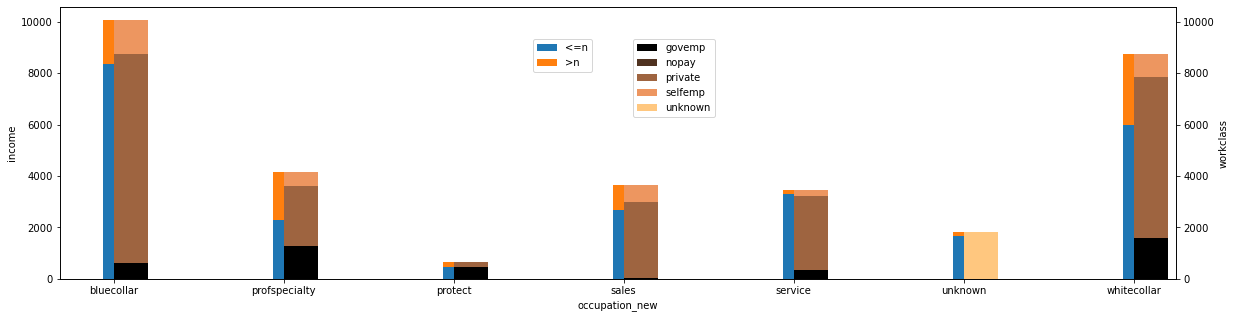

In [1406]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

pd.crosstab(data.occupation_new, data.workclass_new).plot(kind='bar', figsize=(20,5), ax=ax1, position=0, width=0.2,
                                                          stacked=True, colormap=plt.get_cmap('copper'), rot=0)
pd.crosstab(data.occupation_new,data.target).plot(kind='bar', figsize=(20,5), width=0.065, 
                                                  stacked=True, ax=ax2, position=1)

ax1.set_ylabel('income')
ax2.set_ylabel('workclass')
h, l = ax2.get_legend_handles_labels()
ax2.legend(h, l, loc=9, bbox_to_anchor=(0.2, 0.4, 0.5, 0.5))
h, l = ax1.get_legend_handles_labels()
ax1.legend(h, l, loc=9, bbox_to_anchor=(0.3, 0.4, 0.5, 0.5))
plt.show()

<h3>"race"</h3>

race              target
amerindianeskimo  <=n       88.4%
                  >n        11.6%
asianpacislander  <=n       73.4%
                  >n        26.6%
black             <=n       87.3%
                  >n        12.7%
other             <=n       90.8%
                  >n         9.2%
white             <=n       74.4%
                  >n        25.6%
Name: target, dtype: object


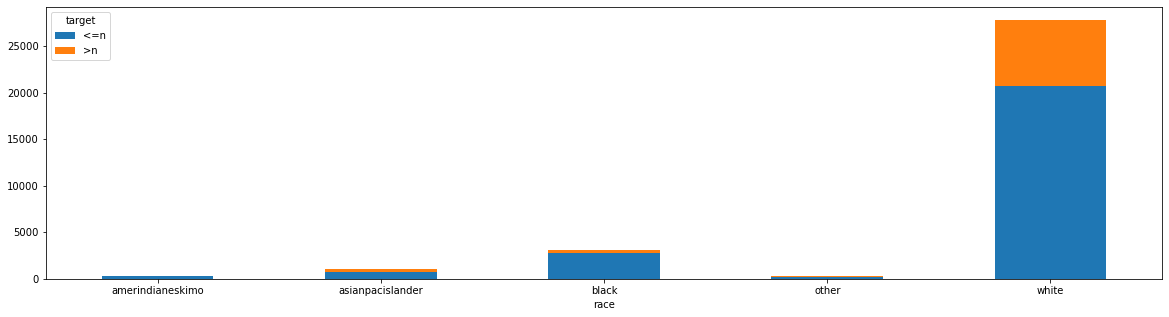

In [1407]:
pd.crosstab(data.race,data.target).plot(kind='bar', figsize=(20,5), stacked=True, rot=0)
print(data.groupby('race').target.value_counts(normalize=True).mul(100).round(1).astype(str) + '%')


<p>
    There are more white people earning more than N in the dataset.
</p>
<p>
    I'll merge relatively not large groups in one - "other".
</p>

In [1408]:
data['race_new'] = data['race']
data['race_new'].replace(['asianpacislander','amerindianeskimo'], 'other', inplace=True)

<AxesSubplot:xlabel='race_new'>

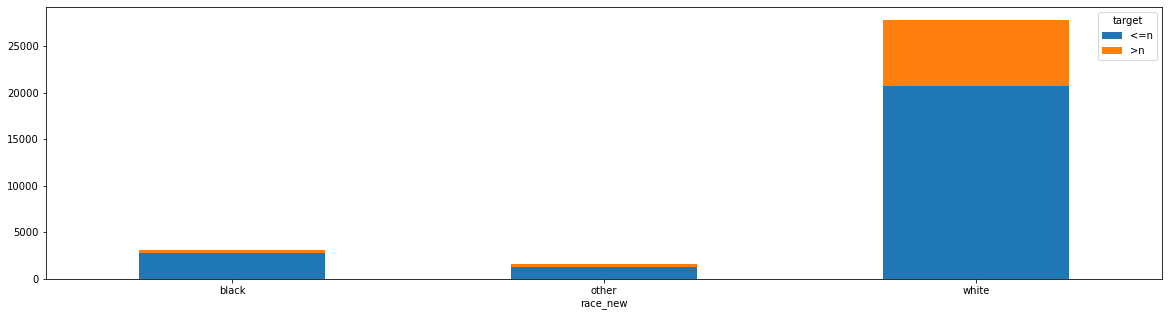

In [1409]:
pd.crosstab(data.race_new,data.target).plot(kind='bar', figsize=(20,5), stacked=True, rot=0)

<h3>"sex"</h3>

sex     target
female  <=n        89.1%
        >n         10.9%
male    <=n        69.4%
        >n         30.6%
other   >n        100.0%
Name: target, dtype: object


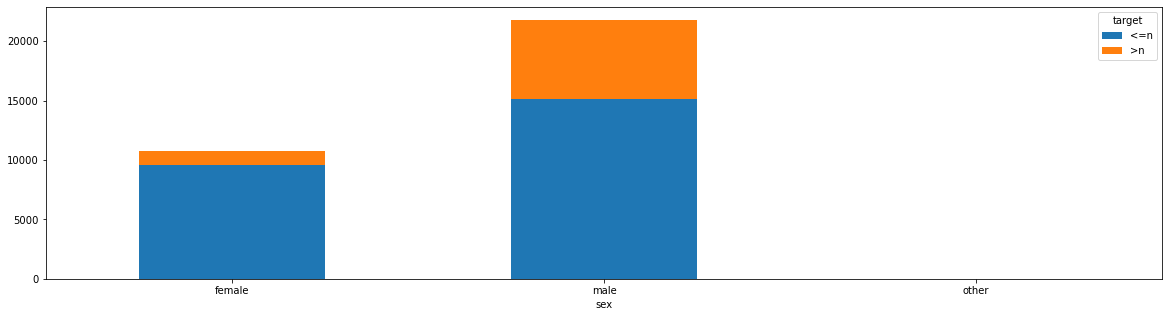

In [1410]:
pd.crosstab(data.sex,data.target).plot(kind='bar', figsize=(20,5), stacked=True, rot=0)
print(data.groupby('sex').target.value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

<p>Here we can observe the "pay gap" - a bigger percent of men make more than N comparing to women.</p>

<h3>"hours_per_week"</h3>

<AxesSubplot:xlabel='hours_per_week'>

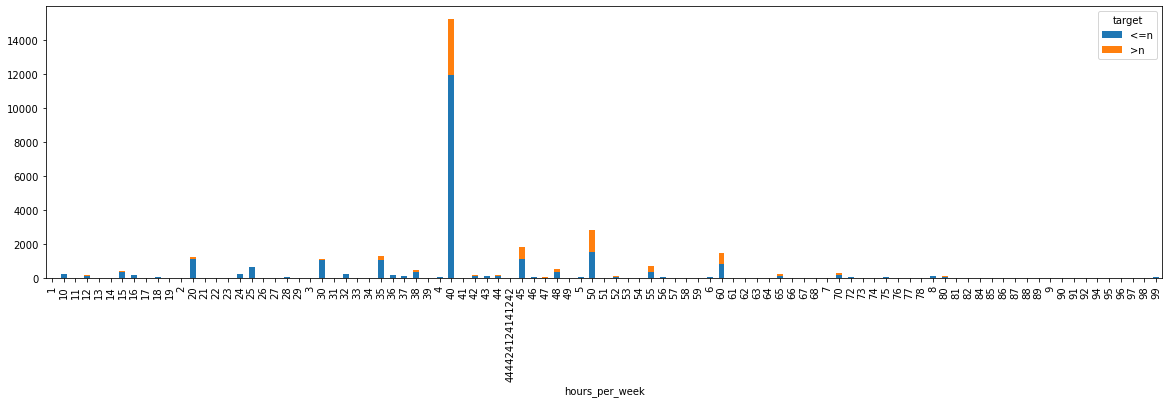

In [1411]:
pd.crosstab(data.hours_per_week,data.target).plot(kind='bar', figsize=(20,5), stacked=True, rot=90)


<p>
    <ol>
        <li>There are some obvious mistakes: "hours..." can't be more than (24*7)</li>
        <li>Among the people which work 40 hours per week or more percent of earning more than N is higher.</li>
    </ol>
</p>
<p>
    I will
    <ol>
        <li>delete mistakes</li>
        <li>create bins: "0-38", "39-41", "42-61", "62-100"</li>
    </ol>
</p>

In [1412]:
data['hours_per_week_new'] = data['hours_per_week']

data['hours_per_week_new'].where([str.isnumeric(str(x).replace('.0', '')) for x in data['hours_per_week_new']], np.nan, inplace=True)

data['hours_per_week_new'] = data['hours_per_week_new'].astype(np.float)
data['hours_per_week_new'].where(data['hours_per_week_new'] <= 100, np.nan, inplace=True)


In [1413]:
bins = [0, 38, 41, 61, 100]
hpw_names = ['undernorm', 'norm', 'overnorm', 'overwork']
data['hours_per_week_new'] = pd.cut(data['hours_per_week_new'], bins, labels=hpw_names)

hours_per_week_new  target
undernorm           <=n       90.5%
                    >n         9.5%
norm                <=n       78.7%
                    >n        21.3%
overnorm            <=n       59.1%
                    >n        40.9%
overwork            <=n       63.7%
                    >n        36.3%
Name: target, dtype: object


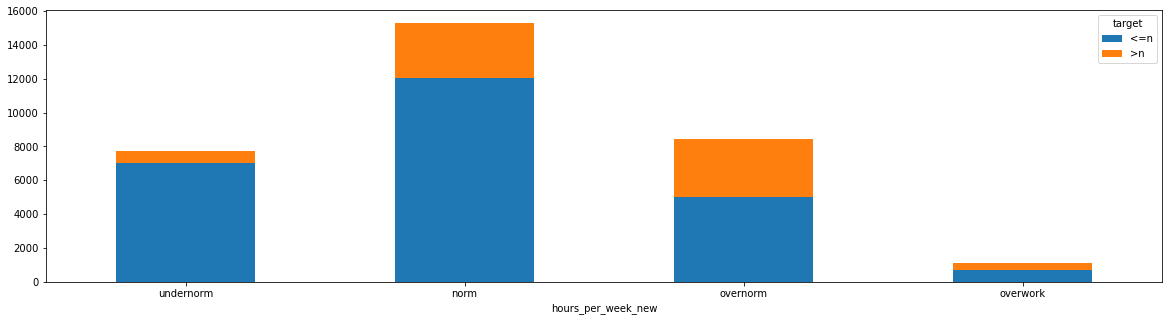

In [1414]:
pd.crosstab(data.hours_per_week_new,data.target).plot(kind='bar', figsize=(20,5), stacked=True, rot=0)
print(data.groupby('hours_per_week_new').target.value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

<p>The more somebody works, the more he earns.</p>

<AxesSubplot:xlabel='Education', ylabel='Percent of cases'>

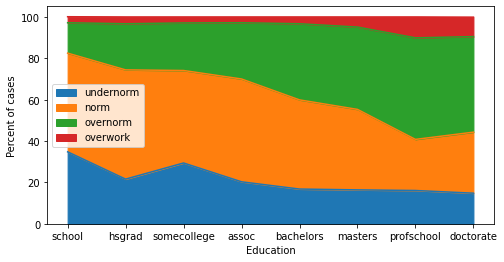

In [1415]:
unique_hpw = ['undernorm', 'norm', 'overnorm', 'overwork']
unique_edn = ['school', 'hsgrad', 'somecollege', 'assoc', 'bachelors', 'masters', 'profschool','doctorate']
groupby = data.groupby('education_new').hours_per_week_new.value_counts(normalize=True).mul(100).round(1)
values = pd.DataFrame(np.zeros((len(unique_edn), len(unique_hpw))), columns=unique_hpw, index=unique_edn)

for i in unique_hpw:
    for j in unique_edn:
        values[i][j] = groupby[(j, i)]

ax = plt.gca()
plt.ylabel('Percent of cases')
plt.xlabel('Education')
values.plot(kind='area', stacked=True, figsize=(8,4), ax=ax)


The higher level of education somebody has the more he works

<h3>"cap_gain" and "cap_loss"</h3>

<AxesSubplot:xlabel='cap_gain'>

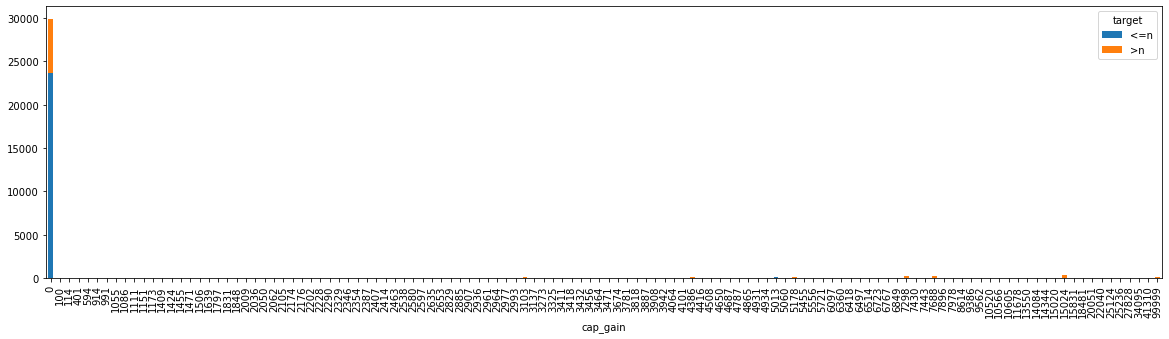

In [1416]:
pd.crosstab(data.cap_gain,data.target).plot(kind='bar', figsize=(20,5), stacked=True, rot=90)

<AxesSubplot:xlabel='cap_loss'>

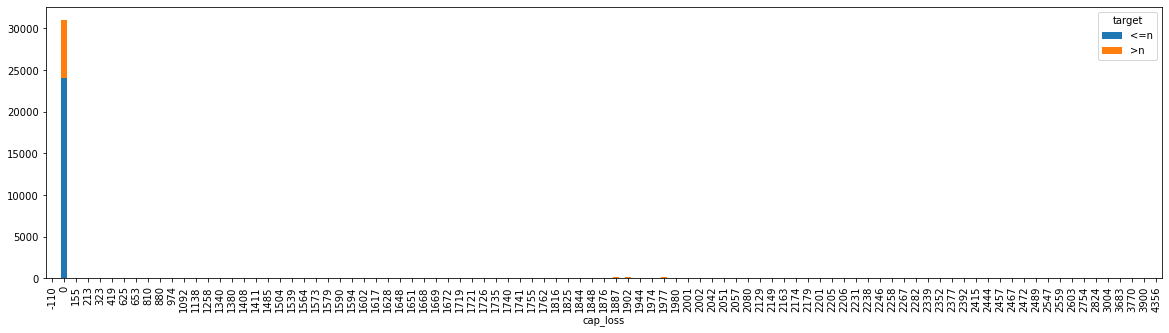

In [1417]:
pd.crosstab(data.cap_loss,data.target).plot(kind='bar', figsize=(20,5), stacked=True, rot=90)

<p>I will create a new feature by subtracting "cap_loss" from "cap_gain"</p>

In [1418]:
data['cap_gain'].where(data['cap_gain'] >= 0, np.nan, inplace=True)
data['cap_loss'].where(data['cap_loss'] >= 0, np.nan, inplace=True)
data = data.assign(cap_gain_loss=data['cap_gain']-data['cap_loss'])

<h3>"final_weight"</h3>

<AxesSubplot:xlabel='final_weight'>

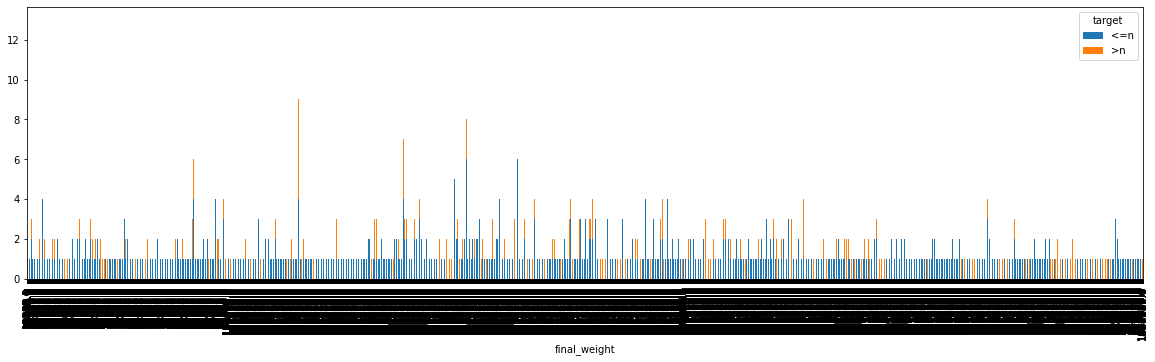

In [1348]:
pd.crosstab(data.final_weight, data.target).plot(kind='bar', figsize=(20,5), stacked=True, rot=90)

<p>
    We know nothing about the feature. It's quite likely that the weight in concrete sample depends on other samples in the dataset. Or it is intrinsic to every single man? I will try to extract any latent parameter in order to make simpler replacement for "final_weight"
</p>
<p> 
    First of all I will check if there is any dependence between a final weight value and income. 
</p>

In [1426]:
maximum = data['final_weight'].max()
minimum = data['final_weight'].min()
print("Maximum: {}, minimum: {}".format(maximum, minimum))
print("Second largest value of final weight: {}\n".format(data['final_weight'][data['final_weight'] < (maximum-1)].max()))
print('Let\'s consider the maximum as outlier and place restrictions on values')

Maximum: 231232153653521512, minimum: -42141
Second largest value of final weight: 1484705

Let's consider the maximum as outlier and place restrictions on values


<p>Let's consider final weight as not negative feature less than 10000000</p>

In [1427]:
abs_max = 10000000
data['final_weight'] = data['final_weight'].where(data['final_weight'] < abs_max, np.nan)
data['final_weight'] = data['final_weight'].where(data['final_weight'] >= 0, np.nan)

Intervals' left edges: 
 [[1, 10812], [2, 159527], [3, 306769], [4, 454011], [5, 601253], [6, 748495], [7, 895737], [8, 1042979], [9, 1190221], [10, 1337463], [11, 1484705]]


<AxesSubplot:xlabel='eqwidth_final_weight'>

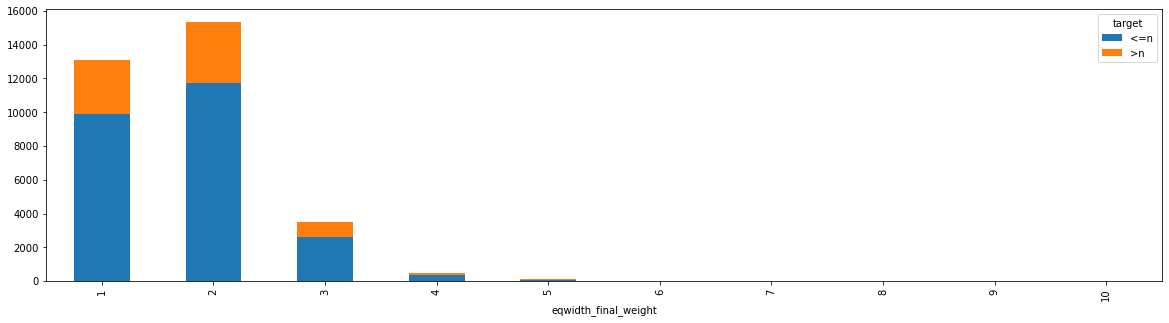

In [1428]:
# Split final weight span in equal intervals  
maximum = data['final_weight'].max()
minimum = data['final_weight'].min()
span = maximum - minimum
N = 10
labels = list(range(1, N+1))
data['eqwidth_final_weight'], bins = pd.cut(data['final_weight'], N, labels=labels, retbins=True)
bins = [[i+1, int(bins[i])] for i in range(len(bins))]
print('Intervals\' left edges: \n', bins)
pd.crosstab(data.eqwidth_final_weight, data.target).plot(kind='bar', figsize=(20,5), stacked=True, rot=90)

[75.4, 76.4, 75.3, 79.2, 79.4, 80.0, 80.0, 80.0, 50.0, 100.0]


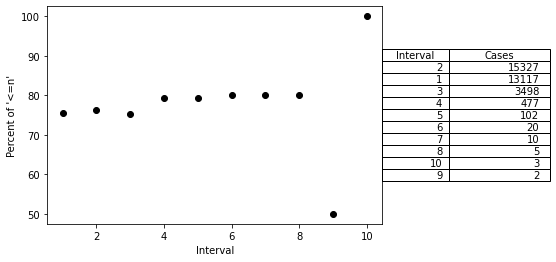

In [1429]:
val_c = data['eqwidth_final_weight'].value_counts()
table = pd.concat([pd.Series(val_c.index.to_list()),pd.Series(val_c.values)], axis=1)
plt.table(table.to_numpy(), loc=14, colWidths=[.2, .3], colLabels=['Interval','Cases'])

groupby = data.groupby('eqwidth_final_weight').target.value_counts(normalize=True).mul(100).round(1)

proba = []
for i in labels:
    proba.append(groupby[(i, '<=n')])
print(proba)

x = range(1, N+1)
y = proba
plt.plot(x, y, 'ok')
plt.ylabel('Percent of \'<=n\'')
plt.xlabel('Interval')
plt.show()

<ol>
    <li>It's evident that value of final weight doesn't really influence income level</li>
    <li>Percent of "<=n" is expected</li>
    <li>The second interval is the densest</li>
</ol>
        
<p>
    Let's look at number of repetitions of particular final weight value - connectedness.    
</p>

In [1430]:
val_c = data['final_weight'].value_counts()
idx = np.expand_dims(val_c.values.tolist(), axis=1)
vals = np.expand_dims(val_c.index.tolist(), axis=1)
val = pd.DataFrame(np.concatenate((vals, idx), axis=1), columns=['vals', 'idx'])
val['idx'] -= 1

dict_val = dict(val.values)

Text(0.5, 1.0, 'Distribution of repetitions in "final_weight"')

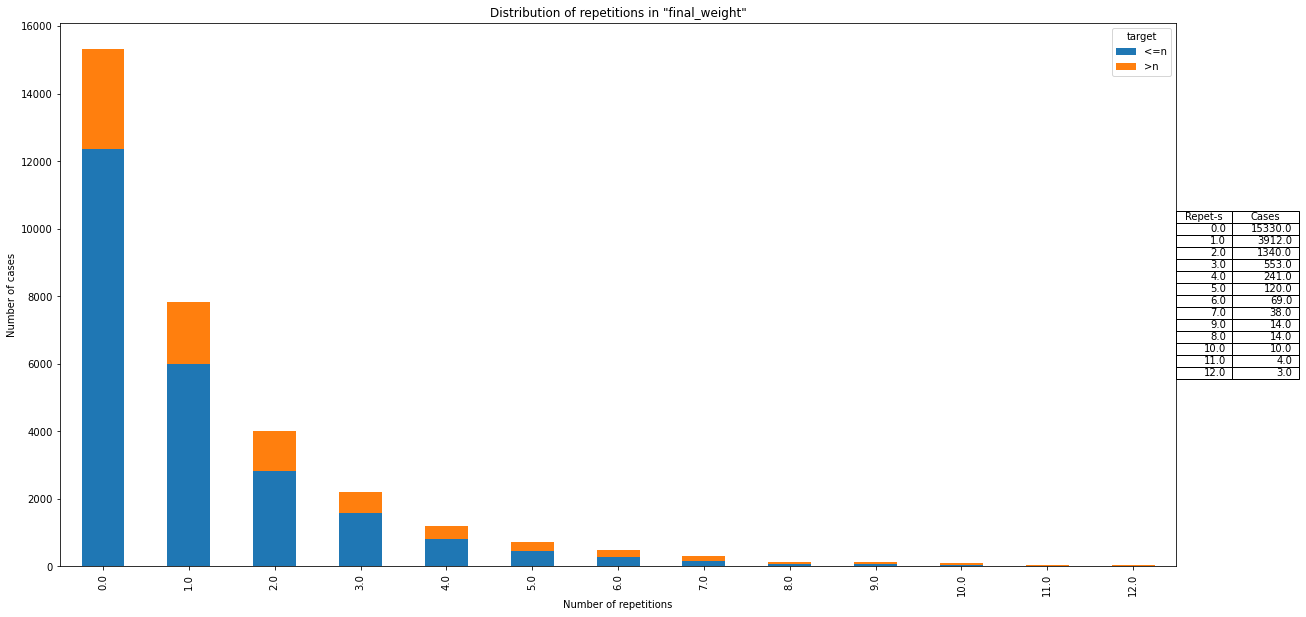

In [1431]:
data['final_weight_new'] = data['final_weight']
data['final_weight_new'] = data['final_weight_new'].map(dict_val, na_action='ignore')

pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.crosstab(data.final_weight_new, data.target).plot(kind='bar', figsize=(20,10), stacked=True, rot=90)

val_c = val['idx'].value_counts()
table = pd.concat([pd.Series(val_c.index.to_list()),val_c], axis=1)

plt.table(table.to_numpy(), loc=14, colWidths=[.05, .06], colLabels=['Repet-s','Cases'])
plt.ylabel('Number of cases')
plt.xlabel('Number of repetitions')
plt.title('Distribution of repetitions in \"final_weight\"')

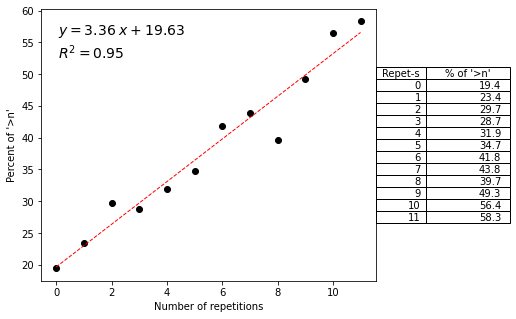

In [1432]:
groupby = data.groupby('final_weight_new').target.value_counts(normalize=True).mul(100).round(1)
max_rep = int((len(groupby)/2)-1)
proba = []
for i in range(max_rep):
    proba.append(groupby[(i, '>n')])

x = list(range(max_rep))
table = [[i, proba[i]] for i in x]
plt.figure(figsize=(6,5))
plt.plot(x, proba, 'ok')

z = np.polyfit(x, proba, 1)
y_hat = np.poly1d(z)(x)
plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.2f}\;x{z[1]:+0.2f}$\n$R^2 = {r2_score(proba,y_hat):0.2f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')

plt.table(table, loc=14, colWidths=[.15, .25], colLabels=['Repet-s','% of \'>n\''])
plt.ylabel('Percent of \'>n\'')
plt.xlabel('Number of repetitions')
plt.show()


<p>
    Connectedness is interesting parameter, but we can't use it instead of "final_weight", since connectedness depends on samples a dataset consists of. Let's look at distribution of connectedness.
</p>

In [1433]:
pd.reset_option('^display')
fw = data[['final_weight','final_weight_new']]
fw_sort1 = fw.sort_values(by=['final_weight_new'])
fw_sort1.columns = ['fw1', 'rep1']
fw_sort2 = fw.sort_values(by=['final_weight'])
fw_sort2.columns = ['fw2', 'rep2']

Maxima of connectedness classes: 
 {0: 1484705.0, 1: 1033222.0, 2: 607848.0, 3: 609789.0, 4: 423222.0, 5: 361888.0, 6: 381153.0, 7: 340917.0, 8: 221172.0, 9: 216129.0, 10: 241998.0, 11: 148995.0, 12: 203488.0}


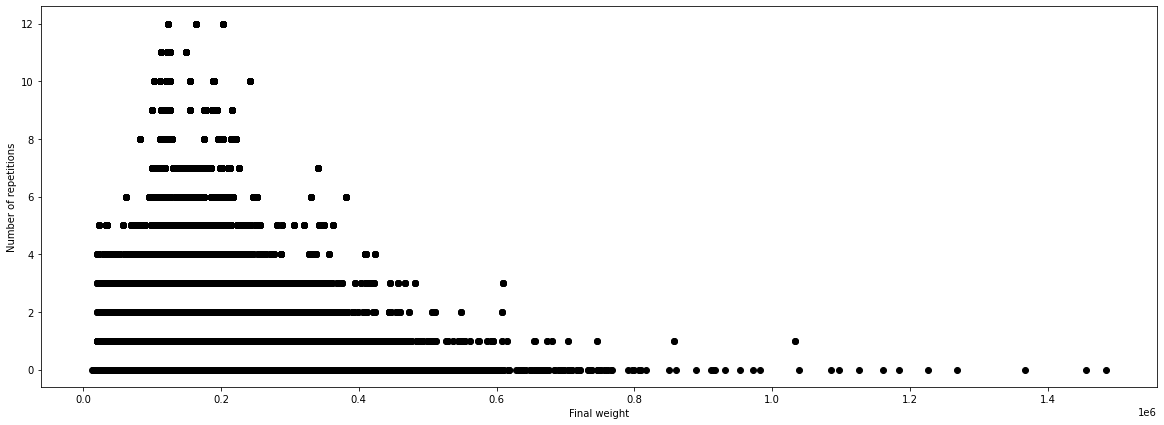

In [1434]:
maxima = []
for i in range(max_rep+1):
    connectedness_i = data['final_weight'][data['final_weight_new'] == i]
    maxima.append(connectedness_i.max())
  
maxima = dict(enumerate(maxima))
print('Maxima of connectedness classes: \n', maxima)

plt.figure(figsize=(20, 7))
plt.plot(fw_sort1['fw1'][fw_sort1['fw1'] < 2000000], fw_sort1['rep1'][fw_sort1['fw1'] < 2000000], 'ok')
#for i in range(max_rep+1):
#    plt.plot([maxima[i], maxima[i]], [0, max_rep], '-r')
plt.ylabel('Number of repetitions')
plt.xlabel('Final weight')
plt.show()

<p>In figure above we can observe that number of possible repetitions gradually decreases when final weight is growing. Let's split up span of final weight values in few groups looking at connectedness.</p>

connectedness_variation  target
high                     <=n       75.8
                         >n        24.2
low                      <=n       77.8
                         >n        22.2
no                       <=n       75.0
                         >n        25.0
Name: target, dtype: float64
high    30727
low      1818
no         16
Name: connectedness_variation, dtype: int64


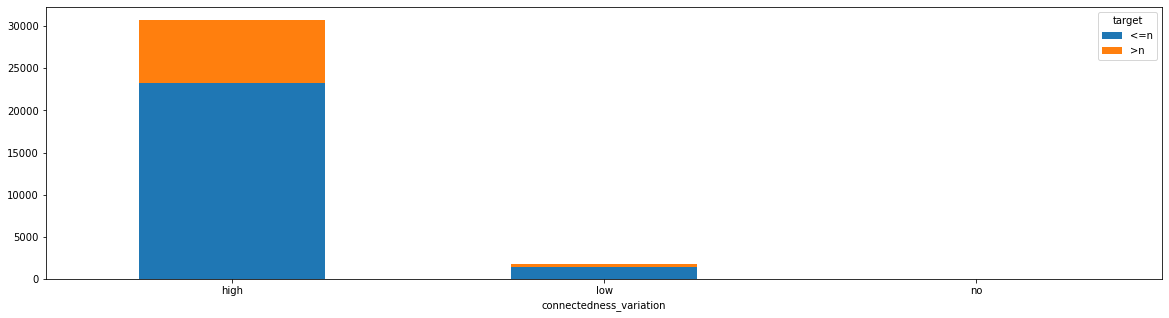

In [1435]:
scd_edge = maxima[5]+10000 # During test dataset preprocessing values of scd_edge and trd_edge will be replaced...
trd_edge = maxima[1]-100000 # ...with the very values assigned to these variables here
bins = [0, scd_edge, trd_edge, abs_max]
cntd_names = ['high', 'low', 'no']
data['connectedness_variation'] = pd.cut(data['final_weight'], bins, labels=cntd_names)

pd.crosstab(data.connectedness_variation, data.target).plot(kind='bar', figsize=(20,5), stacked=True, rot=0)
print(data.groupby('connectedness_variation').target.value_counts(normalize=True).mul(100).round(1))
print(data['connectedness_variation'].value_counts())

In [1436]:
data['final_weight_new'] = data['connectedness_variation']
data.drop(['connectedness_variation', 'eqwidth_final_weight'], axis=1, inplace=True)

<p>Perhaps this way of splitting is reasonable, moreover connectedness is infomative. Anyway, it helps to simplify data.</p>

In [1437]:
pd.set_option("display.max_columns", None)
data.head()

,age,workclass,final_weight,education_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country,target,age_new,workclass_new,education_new,native_country_new,marital_status_new,relationship_new,occupation_new,race_new,hours_per_week_new,cap_gain_loss,final_weight_new
0,39,stategov,77516.0,13,nevermarried,admclerical,notinfamily,white,male,2174.0,0.0,40,unitedstates,<=n,middleaged,govemp,bachelors,us,single,notinfamily,whitecollar,white,norm,2174.0,high
1,50,selfempnotinc,83311.0,13,marriedcivspouse,execmanagerial,husband,white,male,0.0,0.0,13,unitedstates,<=n,senior,selfemp,bachelors,us,married,spouse,whitecollar,white,undernorm,0.0,high
2,38,private,215646.0,9,divorced,handlerscleaners,notinfamily,white,male,0.0,0.0,40,unitedstates,<=n,middleaged,private,hsgrad,us,single,notinfamily,bluecollar,white,norm,0.0,high
3,53,private,234721.0,7,marriedcivspouse,handlerscleaners,husband,black,male,0.0,0.0,40,unitedstates,<=n,senior,private,school,us,married,spouse,bluecollar,black,norm,0.0,high
4,28,private,338409.0,13,marriedcivspouse,profspecialty,wife,black,female,0.0,0.0,40,cuba,<=n,middleaged,private,bachelors,nonus,married,spouse,profspecialty,black,norm,0.0,high


<h3>Deleting unclassified samples</h3>

In [1439]:
to_delete = data['target'][data['target'].isna()].index.to_list()
data = data.drop(to_delete, axis=0)



<h3>Imputing and encoding</h3>

<p>First of all I'll create a final set of features - X. big_X includes uncharned features.</p>

In [1443]:
labels_col_new = ['age_new', 'workclass_new', 'education_new', 'native_country_new', 'marital_status_new', 
                  'relationship_new', 'occupation_new', 'race_new', 'sex', 'hours_per_week_new', 'cap_gain_loss', 
                  'final_weight_new', 'target']
labels_col.remove('education')
big_X = data[labels_col]
X = data[labels_col_new]

big_y = big_X.pop('target')
y = X.pop('target')

<p>Now I'll encode ordinal categorial features</p>

In [1444]:
X.loc[:, 'age_new'] = X['age_new'].map({'middleaged': 1, 'senior': 2, 'young': 0, 'old': 3}, na_action='ignore')
X.loc[:, 'education_new'] = X['education_new'].map({'bachelors':4, 'hsgrad':1, 'school':0, 
                                                     'masters':5, 'somecollege':2, 'assoc':3, 
                                                     'doctorate':7, 'profschool':6}, na_action='ignore')
X.loc[:, 'hours_per_week_new'] = X['hours_per_week_new'].map({'norm':1, 'undernorm':0, 
                                                               'overnorm':2, 'overwork':3}, na_action='ignore')
X.loc[:, 'final_weight_new'] = X['final_weight_new'].map({'high':0, 'low':1, 'no':2}, na_action='ignore')

X.head(3)

/Users/fyodorvanchugov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,age_new,workclass_new,education_new,native_country_new,marital_status_new,relationship_new,occupation_new,race_new,sex,hours_per_week_new,cap_gain_loss,final_weight_new
0,1,govemp,4,us,single,notinfamily,whitecollar,white,male,1,2174.0,0
1,2,selfemp,4,us,married,spouse,whitecollar,white,male,0,0.0,0
2,1,private,1,us,single,notinfamily,bluecollar,white,male,1,0.0,0


<p>Processing numeric and nominal categorial data</p>

In [1445]:
imp = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
X = pd.DataFrame(imp.fit_transform(X), columns=labels_col_new[:-1])

In [1446]:
encode_col = ['workclass_new','native_country_new','marital_status_new','relationship_new',
              'occupation_new','race_new','sex']
encode = X.loc[:, encode_col]

ore = OrdinalEncoder()
encode = pd.DataFrame(ore.fit_transform(encode), columns=encode_col)
X.loc[:, encode_col] = encode.loc[:, encode_col]
X = X.astype(np.float)

y = y.map({'>n':1, '<=n':0})

X.head(3) # Now data is entirely in float

save_for_rfc = X.copy()

<h3>Andrews curves</h3>

<p>Let's visualize data with Andrews curves. Different colours refer to different income classes: '>n' or '<=n'</p>

In [1447]:
for_andrews = save_for_rfc.copy()
columns = for_andrews.columns.to_list()
and_scaling = MinMaxScaler()
for_andrews = pd.DataFrame(and_scaling.fit_transform(for_andrews), columns=columns)

16


KeyError: nan

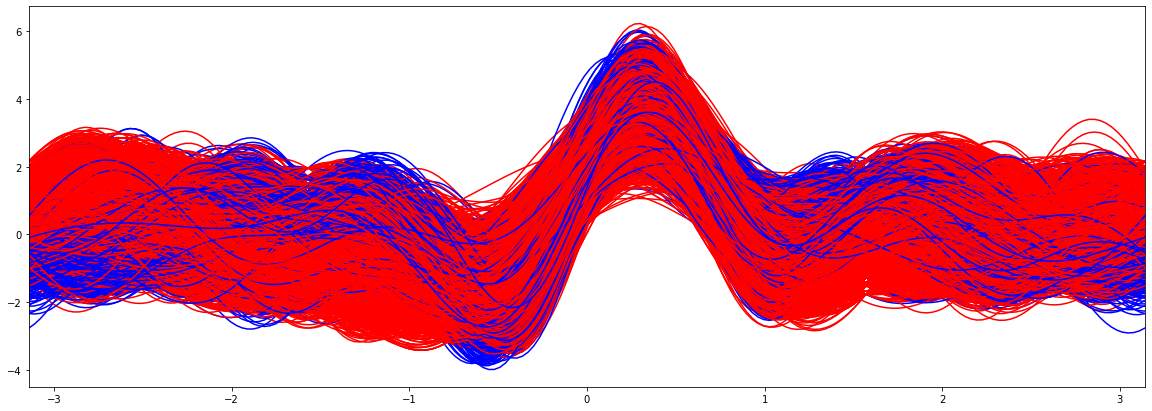

In [1448]:
span = len(for_andrews) - 30
min_e = np.random.randint(1, len(for_andrews)-span, size=1)[0]
print(min_e)

plt.figure(figsize=(20,7))

pd.plotting.andrews_curves(pd.concat([for_andrews.loc[min_e:min_e+span, :], y.loc[min_e:min_e+span]], axis=1), 
                           'target', color=['r','b'])
    

I don't find this visualization real useful, but it at least shows us that classes are not easily separable, but there are some class patterns.

<h3>Correlation matrix</h3>

<p>Let's look at the correlation matrix below. The selected features in the matrix are numeric or ordinal categorial</p>

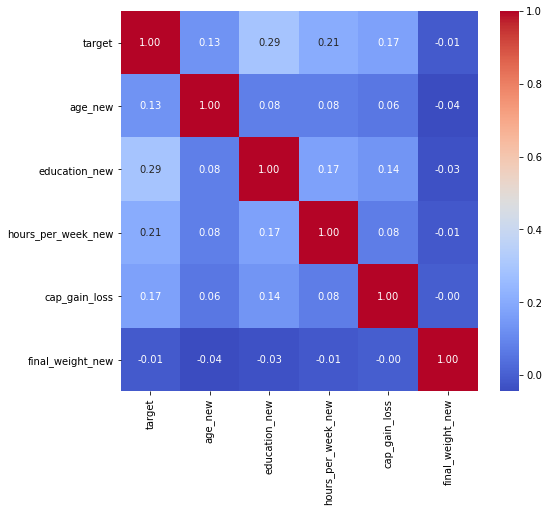

In [1449]:
plt.figure(figsize=(8,7))
corr2 = sns.heatmap(pd.concat([y, X[['age_new', 'education_new', 'hours_per_week_new', 'cap_gain_loss', 'final_weight_new']]], 
                              axis=1).corr(), annot=True, fmt = ".2f", cmap = "coolwarm")

<ol>
    <li>Education level is correlated to income more than other features</li>
    <li>The most uncorrelated to others feature is final weight. Therefore it's reasonable to delete this feature from the dataset as it creates unrequired noise</li>
</ol>

<h3>One-hot and scaling</h3>

In [1450]:
encode = X.loc[:, encode_col] # a dataframe for the features to encode with OneHotEncoder

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(encode)
encode_onehot_col = ohe.get_feature_names(encode_col)
encode = pd.DataFrame(ohe.transform(encode), columns=encode_onehot_col)

encode.columns = [x[:-2] for x in encode.columns]

In [1451]:
X.drop(encode_col, axis=1, inplace=True)

In [1452]:
minmax = MinMaxScaler()
cols = X.columns
X = pd.DataFrame(minmax.fit_transform(X), columns=cols)
X.head(3)

,age_new,education_new,hours_per_week_new,cap_gain_loss,final_weight_new
0,0.333333,0.571429,0.333333,0.062575,0.0
1,0.666667,0.571429,0.000000,0.041742,0.0
2,0.333333,0.142857,0.333333,0.041742,0.0


In [1453]:
X = pd.concat([X, encode], axis=1) # The dataset with data prepared

In [1454]:
X.head(3)

,age_new,education_new,hours_per_week_new,cap_gain_loss,final_weight_new,workclass_new_1,workclass_new_2,workclass_new_3,workclass_new_4,native_country_new_1,marital_status_new_1,relationship_new_1,relationship_new_2,relationship_new_3,relationship_new_4,occupation_new_1,occupation_new_2,occupation_new_3,occupation_new_4,occupation_new_5,occupation_new_6,race_new_1,race_new_2,sex_1,sex_2
0,0.333333,0.571429,0.333333,0.062575,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.666667,0.571429,0.000000,0.041742,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.333333,0.142857,0.333333,0.041742,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


<h3>Loading test dataset</h3>

<p>All the data processing, except visualization, I put in new file.</p>

In [1455]:
import ACI18

In [1456]:
pd.set_option("display.max_columns", None)
data_t = ACI18.get_data('test.txt')
data_t.head()

,age,workclass,final_weight,education_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country,target,age_new,workclass_new,education_new,native_country_new,marital_status_new,relationship_new,occupation_new,race_new,hours_per_week_new,cap_gain_loss,final_weight_new
0,25,private,226802.0,7.0,nevermarried,machineopinspct,ownchild,black,male,0.0,0.0,40.0,unitedstates,<=n,middleaged,private,school,us,single,ownchild,bluecollar,black,norm,0.0,high
1,38,private,89814.0,9.0,marriedcivspouse,farmingfishing,husband,white,male,0.0,0.0,50.0,unitedstates,<=n,middleaged,private,hsgrad,us,married,spouse,bluecollar,white,overnorm,0.0,high
2,28,localgov,336951.0,12.0,marriedcivspouse,protectiveserv,husband,white,male,0.0,0.0,40.0,unitedstates,>n,middleaged,govemp,assoc,us,married,spouse,protect,white,norm,0.0,high
3,44,private,160323.0,10.0,marriedcivspouse,machineopinspct,husband,black,male,7688.0,0.0,40.0,unitedstates,>n,middleaged,private,somecollege,us,married,spouse,bluecollar,black,norm,7688.0,high
4,18,?,103497.0,10.0,nevermarried,?,ownchild,white,female,0.0,0.0,30.0,unitedstates,<=n,young,unknown,somecollege,us,single,ownchild,unknown,white,undernorm,0.0,high


In [1457]:
X_t, y_t, big_X_t, big_y_t, save_for_rfc_t = ACI18.impute_encode_scale(data_t, imp, ore, ohe, minmax)

/Users/fyodorvanchugov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<h3>Random Forest Classifier</h3>

<p>RFC has less strict requirement for data, so I've saved a dataset version without one-hot-encoder performed and "final_weight" deleted as well. I will train RFC with the saved dataset and then decide whether to drop "final_weight" or not.</p>

In [1458]:
rfc = RandomForestClassifier(n_estimators=500)
begin = time.time()
rfc.fit(save_for_rfc, y)
finish = time.time()
print('Test accuracy: {}'.format('%.4f' % rfc.score(save_for_rfc_t, y_t)))


cv_scores = cross_val_score(rfc, save_for_rfc, y, cv=5)
print(cv_scores)
accy1 = cv_scores.mean()
print("CV Accuracy: {}\nTime for fitting: {} min".format('%.4f' % accy1, '%.1f' % ((finish-begin)/60 )))

y_pred = rfc.predict(save_for_rfc_t)

tn, fp, fn, tp  = confusion_matrix(y_t, y_pred, labels=[1,0]).ravel()
recall = recall_score(y_t, y_pred, pos_label=1)
precn = precision_score(y_t, y_pred, pos_label=1)
fscore = f1_score(y_t, y_pred, pos_label=1)
print('Confusion matrix:\n',[[tn, fp],[fn, tp]], '\n')
print('TN: {}\nFP: {}\nFN: {}\nTP: {}\n'.format(tn, fp, fn, tp))

print(classification_report(y_t, y_pred))

Test accuracy: 0.8516
[0.84512663 0.84832668 0.84970832 0.85400675 0.85369972]
CV Accuracy: 0.8502
Time for fitting: 0.2 min
Confusion matrix:
 [[2289, 1557], [859, 11576]] 

TN: 2289
FP: 1557
FN: 859
TP: 11576

              precision    recall  f1-score   support

           0       0.88      0.93      0.91     12435
           1       0.73      0.60      0.65      3846

    accuracy                           0.85     16281
   macro avg       0.80      0.76      0.78     16281
weighted avg       0.84      0.85      0.85     16281



<p>Let's look at feature importance</p>

<AxesSubplot:>

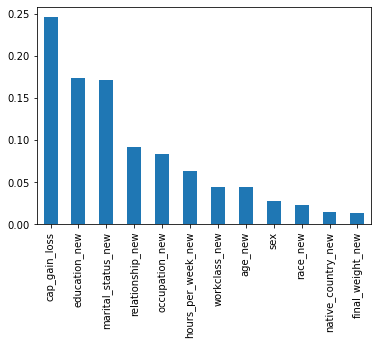

In [1459]:
importance = pd.Series(dict(zip(save_for_rfc.columns.to_list(), rfc.feature_importances_.round(3))))
importance.sort_values(ascending=False).plot(kind='bar')

<p>
    <ol>
        <li>As expected, "final_weight_new" has the least importance.</li>
        <li>Income of a person is highly correlated with capital gain or loss the person has</li>
    </ol>
</p>
<p>Features as "sex", "race_new", "final_weight_new" and "native_country_new" will be deleted.</p>

In [1224]:
save_for_rfc_fs = save_for_rfc.drop(['final_weight_new', 'native_country_new', 'race_new', 'sex'], axis=1).copy()
save_for_rfc_t_fs = save_for_rfc_t.drop(['final_weight_new', 'native_country_new', 'race_new', 'sex'], axis=1).copy()
save_for_rfc_fs.columns

Index(['age_new', 'workclass_new', 'education_new', 'marital_status_new',
       'relationship_new', 'occupation_new', 'hours_per_week_new',
       'cap_gain_loss'],
      dtype='object')

In [1225]:
rfc_2 = RandomForestClassifier(n_estimators=500)
begin = time.time()
rfc_2.fit(save_for_rfc_fs, y)
finish = time.time()
print('Test accuracy: {}'.format('%.4f' % rfc_2.score(save_for_rfc_t_fs, y_t)))


cv_scores = cross_val_score(rfc_2, save_for_rfc_fs, y, cv=5)
print(cv_scores)
accy1 = cv_scores.mean()
print("CV Accuracy: {}\nTime for fitting: {} min".format('%.4f' % accy1, '%.1f' % ((finish-begin)/60 )))

y_pred = rfc_2.predict(save_for_rfc_t_fs)

tn, fp, fn, tp  = confusion_matrix(y_t, y_pred, labels=[1,0]).ravel()
recall = recall_score(y_t, y_pred, pos_label=1)
precn = precision_score(y_t, y_pred, pos_label=1)
fscore = f1_score(y_t, y_pred, pos_label=1)
print('Confusion matrix:\n',[[tn, fp],[fn, tp]], '\n')
print('TN: {}\nFP: {}\nFN: {}\nTP: {}\n'.format(tn, fp, fn, tp))

print(classification_report(y_t, y_pred))

Test accuracy: 0.8545
[0.84942441 0.85124348 0.85185754 0.85630949 0.85723058]
CV Accuracy: 0.8532
Time for fitting: 0.1 min
Confusion matrix:
 [[2273, 1573], [796, 11639]] 

TN: 2273
FP: 1573
FN: 796
TP: 11639

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     12435
           1       0.74      0.59      0.66      3846

    accuracy                           0.85     16281
   macro avg       0.81      0.76      0.78     16281
weighted avg       0.85      0.85      0.85     16281



Random Forest trained on the cut dataset shows slightly better precision and f1-score. 

<h3>SVC</h3>

SVC requires scaled data and the one-hot is preferable. I will drop the less important features for a better performance as well

In [1231]:
X_fs = X.drop(['final_weight_new', 'native_country_new_1', 
               'race_new_1', 'race_new_2', 'sex_1', 'sex_2'], axis=1).copy()
X_t_fs = X_t.drop(['final_weight_new', 'native_country_new_1', 
               'race_new_1', 'race_new_2', 'sex_1', 'sex_2'], axis=1).copy()

X_fs.head(3)

,age_new,education_new,hours_per_week_new,cap_gain_loss,workclass_new_1,workclass_new_2,workclass_new_3,workclass_new_4,marital_status_new_1,relationship_new_1,relationship_new_2,relationship_new_3,relationship_new_4,occupation_new_1,occupation_new_2,occupation_new_3,occupation_new_4,occupation_new_5,occupation_new_6
0,0.333333,0.571429,0.333333,0.062575,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.666667,0.571429,0.000000,0.041742,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.333333,0.142857,0.333333,0.041742,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1232]:
svc = SVC()
begin = time.time()
svc.fit(X_fs, y)
finish = time.time()
print('Test accuracy: {}'.format('%.2f' % svc.score(X_t_fs, y_t)))

cv_scores = cross_val_score(svc, X_fs, y, cv=5)
print(cv_scores)
accy2 = cv_scores.mean()
print("CV Accuracy: {}\nTime for fitting: {} min".format('%.4f' % accy2, '%.1f' % ((finish-begin)/60 )))

y_pred = svc.predict(X_t_fs)

tn, fp, fn, tp  = confusion_matrix(y_t, y_pred, labels=[1,0]).ravel()
recall = recall_score(y_t, y_pred, pos_label=1)
precn = precision_score(y_t, y_pred, pos_label=1)
fscore = f1_score(y_t, y_pred, pos_label=1)
print('Confusion matrix:\n',[[tn, fp],[fn, tp]], '\n')
print('TN: {}\nFP: {}\nFN: {}\nTP: {}\n'.format(tn, fp, fn, tp))

print(classification_report(y_t, y_pred))

Test accuracy: 0.84
[0.83069839 0.83051888 0.83389622 0.83834817 0.83374271]
CV Accuracy: 0.8334
Time for fitting: 0.6 min
Confusion matrix:
 [[2115, 1731], [869, 11566]] 

TN: 2115
FP: 1731
FN: 869
TP: 11566

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     12435
           1       0.71      0.55      0.62      3846

    accuracy                           0.84     16281
   macro avg       0.79      0.74      0.76     16281
weighted avg       0.83      0.84      0.83     16281



Comparing with RFC SVC shows worse results

In [1277]:
svc_2 = SVC(kernel='linear')
begin = time.time()
svc_2.fit(X_fs, y)
finish = time.time()
print('Test accuracy: {}'.format('%.2f' % svc_2.score(X_t_fs, y_t)))

cv_scores = cross_val_score(svc_2, X_fs, y, cv=5)
print(cv_scores)
accy2 = cv_scores.mean()
print("CV Accuracy: {}\nTime for fitting: {} min".format('%.4f' % accy2, '%.1f' % ((finish-begin)/60 )))

y_pred = svc_2.predict(X_t_fs)

tn, fp, fn, tp  = confusion_matrix(y_t, y_pred, labels=[1,0]).ravel()
recall = recall_score(y_t, y_pred, pos_label=1)
precn = precision_score(y_t, y_pred, pos_label=1)
fscore = f1_score(y_t, y_pred, pos_label=1)
print('Confusion matrix:\n',[[tn, fp],[fn, tp]], '\n')
print('TN: {}\nFP: {}\nFN: {}\nTP: {}\n'.format(tn, fp, fn, tp))

print(classification_report(y_t, y_pred))

Test accuracy: 0.84
[0.8362241  0.83082591 0.83358919 0.84709856 0.84172551]
CV Accuracy: 0.8379
Time for fitting: 0.3 min
Confusion matrix:
 [[2318, 1528], [1025, 11410]] 

TN: 2318
FP: 1528
FN: 1025
TP: 11410

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     12435
           1       0.69      0.60      0.64      3846

    accuracy                           0.84     16281
   macro avg       0.79      0.76      0.77     16281
weighted avg       0.84      0.84      0.84     16281



<h3>Comparing Precision-Recall curves</h3>

<p>Ratio of ">n" to "<=n" is about 1:3, meaning that classes are imbalanced, so it's better to use PR curve evaluating the model than ROC curve</p>

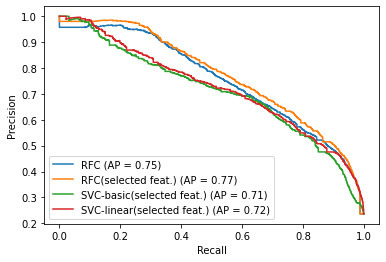

In [1278]:
ax = plt.gca()
rfc_disp = plot_precision_recall_curve(rfc, save_for_rfc_t, y_t, ax=ax, name='RFC')
rfc_2_disp = plot_precision_recall_curve(rfc_2, save_for_rfc_t_fs, y_t, ax=ax, name='RFC(selected feat.)')
svc_disp = plot_precision_recall_curve(svc, X_t_fs, y_t, ax=ax, name='SVC-rbf(selected feat.)')
svc_2_disp = plot_precision_recall_curve(svc_2, X_t_fs, y_t, ax=ax, name='SVC-linear(selected feat.)')
plt.show()

The higest average precision has the last RFC.

<h3>Comparing ROC curves</h3>

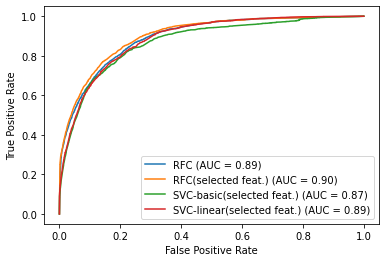

In [1279]:
ax = plt.gca()
rfc_disp = plot_roc_curve(rfc, save_for_rfc_t, y_t, ax=ax, name='RFC')
rfc_2_disp = plot_roc_curve(rfc_2, save_for_rfc_t_fs, y_t, ax=ax, name='RFC(selected feat.)')
svc_disp = plot_roc_curve(svc, X_t_fs, y_t, ax=ax, name='SVC-rbf(selected feat.)')
svc_2_disp = plot_roc_curve(svc_2, X_t_fs, y_t, ax=ax, name='SVC-linear(selected feat.)')
plt.show()

The last RFC shows the best result again.

<h3>Learning curves</h3>

Learning curves can shows us if there is bias or variance problem in a model or not

In [ ]:
%%time
plt.figure()
train_sizes, train_scores_rfc, test_scores_rfc = learning_curve(rfc, save_for_rfc, y, 
                                                                train_sizes=np.linspace(0.1, 1, 10), 
                                                                scoring='neg_log_loss', cv=10)

plt.plot(train_sizes, -test_scores_rfc.mean(1), 'o-', color="r", label="CV")
plt.plot(train_sizes, -train_scores_rfc.mean(1), 'o-', color="b", label="train")
plt.legend()
plt.title('Learning curve for RFC')
plt.ylabel('Log-loss')
plt.xlabel('Size of dataset')
plt.show()

Without less important features:

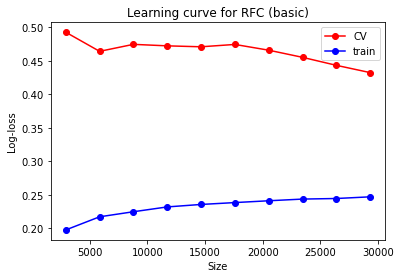

CPU times: user 9min 43s, sys: 17 s, total: 10min
Wall time: 10min 37s


In [1229]:
%%time
plt.figure()
train_sizes, train_scores_rfc, test_scores_rfc = learning_curve(rfc_2, save_for_rfc_fs, y, 
                                                                train_sizes=np.linspace(0.1, 1, 10), 
                                                                scoring='neg_log_loss', cv=10)

plt.plot(train_sizes, -test_scores_rfc.mean(1), 'o-', color="r", label="CV")
plt.plot(train_sizes, -train_scores_rfc.mean(1), 'o-', color="b", label="train")
plt.legend()
plt.title('Learning curve for RFC (selected feat.)')
plt.ylabel('Log-loss')
plt.xlabel('Size of dataset')
plt.show()

The plots above look like there is variance (big gap between "CV" and "train" lines, the form of "train" line).

Perhaps, additional samples could help to decrease the loss

<h3>Result</h3>
<p>
    <ol>
        <li>
            <b>
                Reached parameters:
            </b><br> 
                Accuracy: 85% <br> 
                W. recall: 0.85 <br> 
                W. precision: 0.85 <br> 
                W. f1-score: 0.85 <br> 
                AP: 0.77 <br> 
                ROC AUC: 0.90 <br>
        </li>
        <li>'final_weight', 'native_country', 'race', 'sex' are not used in the final model</li>
        <li>Assumption: increase of a training set can lead to better performance of the model</li>
    </ol>    
</p>